# 1 Imports

In [ ]:
import os
import json
import base64
from dotenv import load_dotenv
from openai import OpenAI
import gradio as gr
from io import BytesIO
from PIL import Image

# 2 Connect to OpenAI

In [25]:
# Load environment variables in a file called .env

load_dotenv()
api_key = os.getenv('OPEN_API_KEY')
model = 'gpt-4o-mini'
openai = OpenAI()

# 3 OpenAI Model Configuration

In [26]:
system_message = "You are an helpful assistant"
system_message += "Give short, courteous answers, no more than 1 sentence."
system_message += "Always be accurate. If you don't know the answer, say so."

In [27]:
def chat(message, history):

    messages = [{'role': 'system', 'content': system_message}]
    for human, assistant_message in history:
        messages.append({'role': 'user', 'content': human})
        messages.append({'role': 'assistant', 'content': assistant_message})
    messages.append({'role': 'user', 'content': message})
    
    response = openai.chat.completions.create(
        model = 'gpt-4o-mini',
        messages = messages,
    )

    return response.choices[0].message.content

# 4 Gradio Assistant

## 4.1 Basic Assistant

In [28]:
gr.ChatInterface(fn=chat).launch()

c:\Users\filip\GitHub\Mastering-LLM-Agentic-AI\venv\Lib\site-packages\gradio\components\chatbot.py:290: UserWarning: The 'tuples' format for chatbot messages is deprecated and will be removed in a future version of Gradio. Please set type='messages' instead, which uses openai-style 'role' and 'content' keys.
  warnings.warn(


* Running on local URL:  http://127.0.0.1:7863

To create a public link, set `share=True` in `launch()`.


## 4.2 Assistant with Tools

In [29]:
ticket_prices = {'london': '$ 100', 'paris': '$ 200', 'berlin': '$ 150', 'new york': '$ 300'}

def get_ticket_price(destination_city):

    print(f"Tool get_ticket_price called for {destination_city}")
    city = destination_city.lower()

    return ticket_prices.get(city, 'Unknown')

In [30]:
# There's a particular dictionary structure that's required to describe our function:

price_function = {
    "name": "get_ticket_price",
    "description": "Get the price of a ticket to a destination city.",
    "parameters": {
        "type": "object",
        "properties": {
            "destination_city": {
                "type": "string",
                "description": "The destination city for the ticket."
            }
        },
        "required": ["destination_city"],
        "additionalProperties": False,
    },
}

In [31]:
tools = [{'type': 'function', 'function': price_function}]

In [40]:
# Function to deal with the tool call

def handle_tool_call(message):

    tool_call = message.tool_calls[0]
    arguments = json.loads(tool_call.function.arguments)
    city = arguments.get('destination_city')
    price = get_ticket_price(city)
    response = {
        'role': 'tool',
        'content': json.dumps({'destination_city': city, 'price': price}),
        'tool_call_id': message.tool_calls[0].id
    }

    return response, city

In [43]:
def chat(message, history):

    messages = [{'role': 'system', 'content': system_message}]
    for human, assistant_message in history:
        messages.append({'role': 'user', 'content': human})
        messages.append({'role': 'assistant', 'content': assistant_message})
    messages.append({'role': 'user', 'content': message})
    
    response = openai.chat.completions.create(
        model = 'gpt-4o-mini',
        messages = messages,
        tools = tools,
    )

    if response.choices[0].finish_reason == 'tool_calls':
        message = response.choices[0].message
        response, city = handle_tool_call(message)
        messages.append(message)
        messages.append(response)
        
        response = openai.chat.completions.create(
            model = 'gpt-4o-mini',
            messages = messages,
        )

    return response.choices[0].message.content

In [ ]:
gr.ChatInterface(fn=chat).launch()

c:\Users\filip\GitHub\Mastering-LLM-Agentic-AI\venv\Lib\site-packages\gradio\components\chatbot.py:290: UserWarning: The 'tuples' format for chatbot messages is deprecated and will be removed in a future version of Gradio. Please set type='messages' instead, which uses openai-style 'role' and 'content' keys.
  warnings.warn(


* Running on local URL:  http://127.0.0.1:7868

To create a public link, set `share=True` in `launch()`.


Tool get_ticket_price called for London
Tool get_ticket_price called for Paris


## 4.3 Multi-modal Assistant

In [46]:
def artist(city):

    image_response = openai.images.generate(
        model = 'dall-e-3',
        prompt = f"An image representing a vacation in {city}, showing tourist spots and everthing unique about {city} in a vibrant pop-up art style",
        size = '1024x1024',
        n=1,
        response_format = 'b64_json'
    )

    image_base64 = image_response.data[0].b64_json
    image_data = base64.b64decode(image_base64)
    return Image.open(BytesIO(image_data))

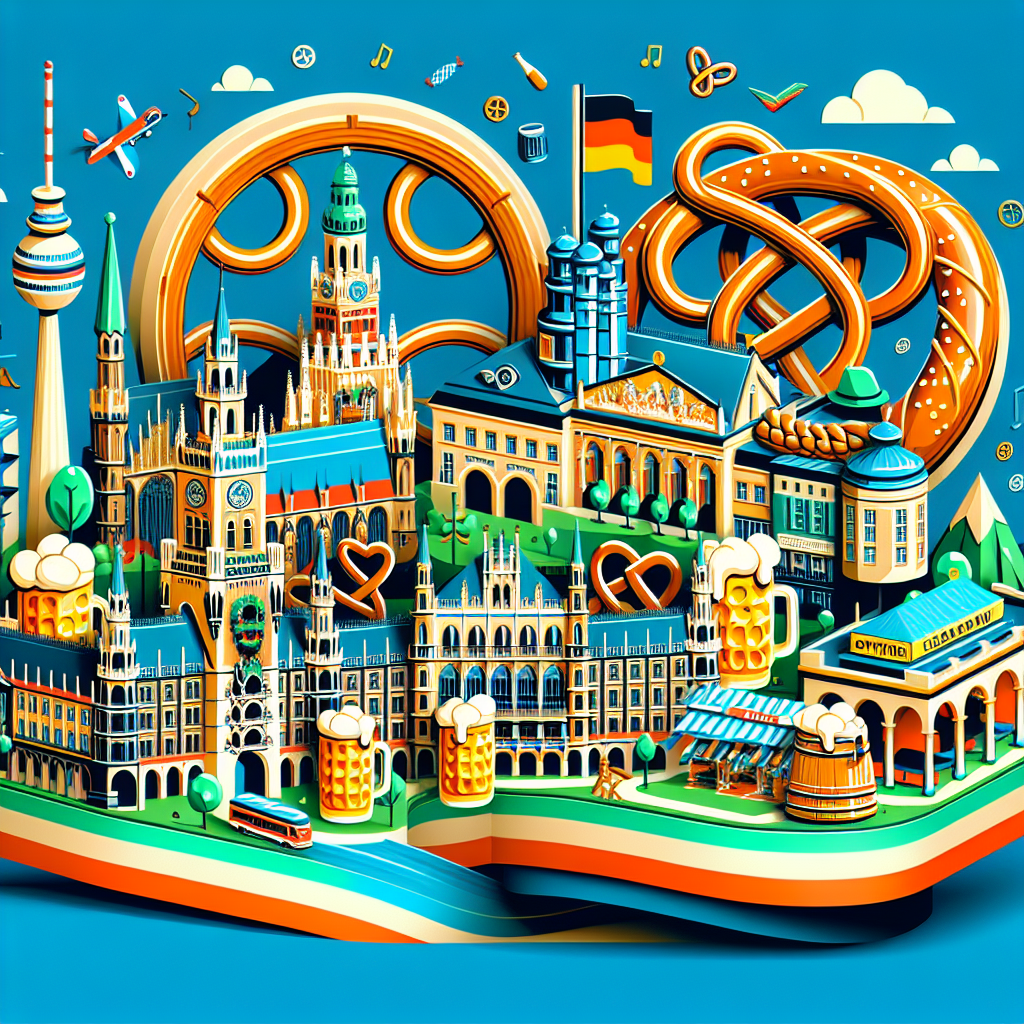

In [47]:
image = artist('Munich')
display(image)

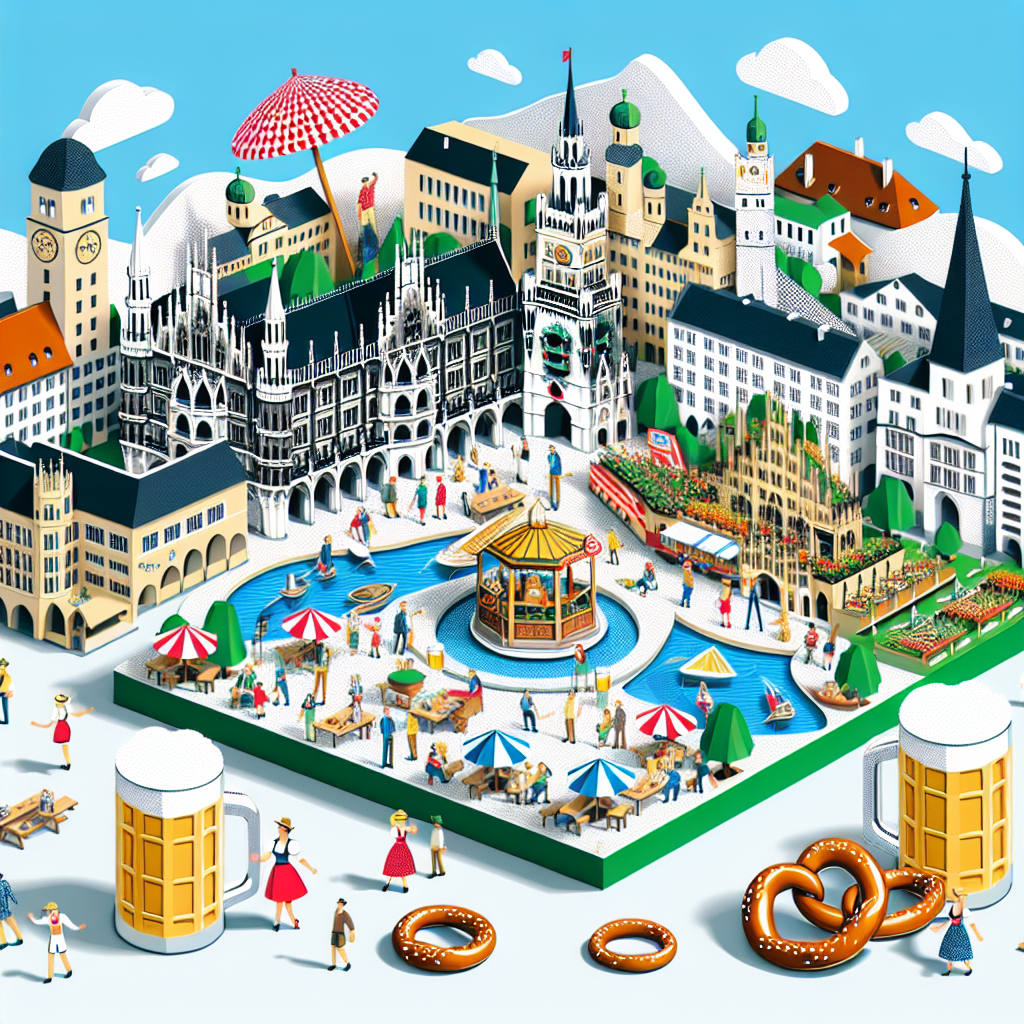

In [48]:
image = artist('Munich')
display(image)

In [67]:
def chat(message, history):

    image = None
    conversation = [{'role': 'system', 'content': system_message}]
    for human, assistant in history:
        conversation.append({'role': 'user', 'content': human})
        conversation.append({'role': 'assistant', 'content': assistant})
    conversation.append({'role': 'user', 'content': message})
    
    response = openai.chat.completions.create(
        model = 'gpt-4o-mini',
        messages = conversation,
        tools = tools,
    )

    if response.choices[0].finish_reason == 'tool_calls':
        message = response.choices[0].message
        response, city = handle_tool_call(message)
        conversation.append(message)
        conversation.append(response)
        image = artist(city)
        
        response = openai.chat.completions.create(
            model = 'gpt-4o-mini',
            messages = conversation,
        )

    reply = response.choices[0].message.content
    return reply, image

In [71]:
with gr.Blocks() as ui:
    
    with gr.Row():
        chatbot = gr.Chatbot(height='500')
        image_output = gr.Image(height='500')

    with gr.Row():
        msg = gr.Textbox(label='Chat with our AI Assistant:')

    with gr.Row():
        clear = gr.Button('Clear')

    def user(user_message, history):
        return "", history + [[user_message, None]]

    def bot(history):
        user_message = history[-1][0]
        bot_message, image = chat(user_message, history[:-1])
        history[-1][1] = bot_message
        return history, image

    msg.submit(user, [msg, chatbot], [msg, chatbot], queue = 'False').then(
        bot, chatbot, [chatbot, image_output]
    )
    clear.click(lambda: None, None, chatbot, queue = 'False')

ui.launch()

c:\Users\filip\GitHub\Mastering-LLM-Agentic-AI\venv\Lib\site-packages\gradio\components\chatbot.py:284: UserWarning: You have not specified a value for the `type` parameter. Defaulting to the 'tuples' format for chatbot messages, but this is deprecated and will be removed in a future version of Gradio. Please set type='messages' instead, which uses openai-style dictionaries with 'role' and 'content' keys.
  warnings.warn(


* Running on local URL:  http://127.0.0.1:7870

To create a public link, set `share=True` in `launch()`.


Tool get_ticket_price called for London
